Tips to navigate the notebook: Everytime that you need to verify a claim made in the report, search for the corresponding section name. The code for the section Redeployment is in the other notebooks.

In [1]:
import os
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, auc, roc_auc_score
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('25_January_Final.json') as json_file:
    data = json.load(json_file)

In [3]:
path = os.path.join('data', 'train.csv')
train_df = pd.read_csv(path)
train_df = train_df.drop_duplicates()
train_df = train_df[train_df.VehicleSearchedIndicator == True]
train_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
71,True,False,Bridgeport,10/01/2013 12:46:00 AM,Bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
143,True,True,Milford,10/01/2013 01:50:00 AM,MILFORD,E,2325,True,I,Defective Lights,30.0,N,W,M,True
184,True,False,Torrington,10/01/2013 03:49:00 AM,Torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True
203,True,False,State Police,10/01/2013 05:30:00 AM,TOLLAND,V,1000002715,False,C,Other,19.0,N,B,M,False
212,True,False,Greenwich,10/01/2013 05:47:00 AM,RIVERSIDE,V,110993,False,N,Speed Related,34.0,M,B,M,False


In [4]:
trial_df = pd.DataFrame(data["values"], columns = ['id', 'observation_id', 'observation', 'proba', 'true_class', 'predicted_class']) 
trial_df.head()

,id,observation_id,observation,proba,true_class,predicted_class
0,7733,7169,"{""id"": 7169, ""observation"": {""Department Name""...",0.473302,NaN,1
1,7734,7170,"{""id"": 7170, ""observation"": {""Department Name""...",0.277561,NaN,0
2,7735,7171,"{""id"": 7171, ""observation"": {""Department Name""...",0.277561,NaN,0
3,7736,7172,"{""id"": 7172, ""observation"": {""Department Name""...",0.233582,NaN,0
4,4,3,"{""id"": 3, ""observation"": {""Department Name"": ""...",0.324282,1.0,0


Sections Summary, Model Performance and Fairness

In [5]:
# Get only observations that received the true_class to calculate the performance metrics
trial_df = trial_df[(trial_df.true_class == 1) | (trial_df.true_class == 0)]

In [6]:
precision_score(trial_df.true_class, trial_df.predicted_class)

0.5825575698187163

In [7]:
recall_score(trial_df.true_class, trial_df.predicted_class)

0.6623955431754874

In [8]:
obs_id = trial_df.observation.apply(lambda x: json.loads(x)['id'])
obs = trial_df.observation.apply(lambda x: json.loads(x)['observation']).apply(pd.Series).set_index(obs_id)
obs = obs.reset_index().rename(columns={"observation": "observation_id"})
obs.head()

,observation_id,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,3,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
1,6,Naugatuck,05/16/2018 11:43:00 AM,NAUGATUCK,I,100296,True,I,Administrative Offense,23.0,H,W,M,False
2,7,Naugatuck,05/16/2018 11:43:00 AM,NAUGATUCK,I,100296,True,I,Administrative Offense,23.0,H,W,M,False
3,8,Glastonbury,05/16/2018 12:17:00 PM,Glastonbury,V,BWC0441,True,O,Moving Violation,24.0,N,B,F,False
4,9,Glastonbury,05/16/2018 12:17:00 PM,Glastonbury,V,BWC0441,True,O,Moving Violation,24.0,N,B,F,False


In [9]:
trial_df = trial_df.drop(columns=["observation"])
trial_df = trial_df.merge(obs, on='observation_id')
trial_df.head()

,id,observation_id,proba,true_class,predicted_class,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,4,3,0.324282,1.0,0,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
1,7,6,0.259167,0.0,0,Naugatuck,05/16/2018 11:43:00 AM,NAUGATUCK,I,100296,True,I,Administrative Offense,23.0,H,W,M,False
2,8,7,0.259167,0.0,0,Naugatuck,05/16/2018 11:43:00 AM,NAUGATUCK,I,100296,True,I,Administrative Offense,23.0,H,W,M,False
3,9,8,0.581199,0.0,1,Glastonbury,05/16/2018 12:17:00 PM,Glastonbury,V,BWC0441,True,O,Moving Violation,24.0,N,B,F,False
4,10,9,0.581199,0.0,1,Glastonbury,05/16/2018 12:17:00 PM,Glastonbury,V,BWC0441,True,O,Moving Violation,24.0,N,B,F,False


In [10]:
precision_female = precision_score(trial_df[trial_df.SubjectSexCode == 'F'].true_class, trial_df[trial_df.SubjectSexCode == 'F'].predicted_class)
precision_male = precision_score(trial_df[trial_df.SubjectSexCode == 'M'].true_class, trial_df[trial_df.SubjectSexCode == 'M'].predicted_class)
precision_hispanic = precision_score(trial_df[trial_df.SubjectEthnicityCode == 'H'].true_class, trial_df[trial_df.SubjectEthnicityCode == 'H'].predicted_class)
precision_middle_eastern = precision_score(trial_df[trial_df.SubjectEthnicityCode == 'M'].true_class, trial_df[trial_df.SubjectEthnicityCode == 'M'].predicted_class)
precision_not_applicable_ethnicity = precision_score(trial_df[trial_df.SubjectEthnicityCode == 'N'].true_class, trial_df[trial_df.SubjectEthnicityCode == 'N'].predicted_class)
precision_white = precision_score(trial_df[trial_df.SubjectRaceCode == 'W'].true_class, trial_df[trial_df.SubjectRaceCode == 'W'].predicted_class)
precision_black = precision_score(trial_df[trial_df.SubjectRaceCode == 'B'].true_class, trial_df[trial_df.SubjectRaceCode == 'B'].predicted_class)
precision_indian = precision_score(trial_df[trial_df.SubjectRaceCode == 'I'].true_class, trial_df[trial_df.SubjectRaceCode == 'I'].predicted_class)
precision_asian = precision_score(trial_df[trial_df.SubjectRaceCode == 'A'].true_class, trial_df[trial_df.SubjectRaceCode == 'A'].predicted_class)
print(precision_female)
print(precision_male)
print(precision_hispanic)
print(precision_middle_eastern)
print(precision_not_applicable_ethnicity)
print(precision_white)
print(precision_black)
print(precision_indian)
print(precision_asian)

0.5751789976133651
0.5844636251541308
0.547085201793722
0.0
0.5924764890282131
0.5994087213599408
0.5505952380952381
0.5
0.5


C:\Anaconda3\envs\capstone_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Section Population Analysis

In [11]:
for i in np.unique(trial_df['Department Name'].values):
    if i not in np.unique(train_df['Department Name'].values):
        print(i)

In [12]:
department_not_in_production = []
for i in np.unique(train_df['Department Name'].values):
    if i not in np.unique(trial_df['Department Name'].values):
        department_not_in_production.append(i)
        
print(department_not_in_production)
print(len(department_not_in_production))

['CCSU', 'Canton', 'ECSU', 'MET DIST WATER AUTHORITY', 'MTA', 'MTA Stamford', 'Madison', 'Middlebury', 'Orange', 'Redding', 'State Police', 'WCSU']
12


In [13]:
train_df = train_df.sort_values(by=['InterventionDateTime'])
train_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
127366,True,False,Milford,01/01/2014 01:00:00 AM,MILFORD,V,2117,False,C,Moving Violation,26.0,N,W,M,False
127833,True,True,Stratford,01/01/2014 01:01:00 PM,STRATFORD,V,10154,True,O,Other,30.0,M,B,F,False
127384,True,False,Willimantic,01/01/2014 01:08:00 AM,WILLIMANTIC,V,319,True,N,Stop Sign,28.0,M,W,F,True
127397,True,False,Norwalk,01/01/2014 01:14:00 AM,NORWALK,V,173,True,O,Other,45.0,N,B,M,True
127865,True,False,Wethersfield,01/01/2014 01:38:00 PM,Wethersfield,V,PJM0164,True,C,Display of Plates,19.0,H,W,M,False


In [14]:
train_df.tail()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
2076241,True,True,West Hartford,12/31/2017 11:55:00 AM,West Hartford,V,1000002072,True,O,Moving Violation,41.0,N,W,M,False
2076877,True,False,Wilton,12/31/2017 11:57:00 PM,WILTON,I,120000067,True,O,Moving Violation,60.0,N,W,F,True
2076005,True,False,Farmington,12/31/2017 12:11:00 AM,FARMINGTON,V,400,False,O,Defective Lights,21.0,H,W,M,False
2076006,True,True,Coventry,12/31/2017 12:12:00 AM,Coventry,V,20272,True,O,Speed Related,22.0,N,W,M,False
2076012,True,True,Naugatuck,12/31/2017 12:21:00 AM,Naugatuck,V,PL31,True,O,Defective Lights,24.0,N,W,F,False


In [15]:
trial_df = trial_df.sort_values(by=['InterventionDateTime'])
trial_df.head()

,id,observation_id,proba,true_class,predicted_class,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
5,11,10,0.562560,1.0,1,New Britain,05/16/2018 01:19:00 PM,New Britain,V,684,False,O,Window Tint,30.0,N,B,M,True
6,12,11,0.562560,1.0,1,New Britain,05/16/2018 01:19:00 PM,New Britain,V,684,False,O,Window Tint,30.0,N,B,M,True
8,14,13,0.276715,1.0,0,CSP Troop C,05/16/2018 02:36:00 PM,ELLINGTON,V,1000003160,False,C,Speed Related,48.0,N,W,F,False
7,13,12,0.276715,1.0,0,CSP Troop C,05/16/2018 02:36:00 PM,ELLINGTON,V,1000003160,False,C,Speed Related,48.0,N,W,F,False
1816,2,0,0.388104,0.0,1,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False


In [16]:
trial_df.tail()

,id,observation_id,proba,true_class,predicted_class,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
4648,5489,4925,0.134633,0.0,0,Seymour,07/12/2018 12:39:00 AM,Seymour,E,356,True,N,Defective Lights,44.0,N,B,M,False
4678,5518,4954,0.244755,0.0,0,Hartford,07/12/2018 12:41:00 PM,Hartford,V,655,True,C,Display of Plates,28.0,N,B,M,True
4679,5519,4955,0.244755,0.0,0,Hartford,07/12/2018 12:41:00 PM,Hartford,V,655,True,C,Display of Plates,28.0,N,B,M,True
4649,5490,4926,0.519865,0.0,1,Plymouth,07/12/2018 12:57:00 AM,Terryville,V,24,True,O,Speed Related,22.0,N,W,M,True
4650,5491,4927,0.519865,0.0,1,Plymouth,07/12/2018 12:57:00 AM,Terryville,V,24,True,O,Speed Related,22.0,N,W,M,True


In [17]:
for i in np.unique(trial_df.InterventionLocationName.values):
    if i not in train_df.InterventionLocationName.values:
        print(i)

YALESVILLE


In [62]:
department_not_in_production_data = []
for i in np.unique(train_df.InterventionLocationName.astype(str).values):
    if i not in np.unique(trial_df.InterventionLocationName.values):
        department_not_in_production_data.append(i)
print(len(department_not_in_production_data))

524


In [21]:
trial_df.InterventionReasonCode.value_counts()

V    3650
E     840
I     510
Name: InterventionReasonCode, dtype: int64

In [63]:
train_df.InterventionReasonCode.value_counts()

V    52896
E    11942
I     5041
Name: InterventionReasonCode, dtype: int64

In [23]:
officers_not_present_in_training_data = []
for i in np.unique(trial_df.ReportingOfficerIdentificationID.values):
    if i not in train_df.ReportingOfficerIdentificationID.values:
        officers_not_present_in_training_data.append(i)
print(officers_not_present_in_training_data)
print(len(officers_not_present_in_training_data))

['01', '012', '0149', '02', '0400', '048', '062', '099', '100000072', '1000002276', '1000002284', '1000002291', '100000660', '1000194', '1000241', '1000243', '1000298', '100056', '1001084', '1001096', '100160', '100214', '100247', '100248', '100260', '100275', '100296', '100319', '100330', '100362', '102968', '102975', '1108', '120000226', '1235', '17309', '200058', '211767', '211768', '211774', '211780', '211784', '213240', '213247', '213248', '213255', '2151', '215208', '215219', '300009', '300013', '300026', '30193', '3145', '3146', '3160', '42623', '53802', '55963', '56', '655', '6641', '6643', '671', '71562', '725', '820', '851', '88342', '88352', '938', '9592', 'ARGJ56', 'DAMJ34', 'K9-3', 'LTC0438', 'MCJJ98', 'MCSJ07', 'MLKI91', 'P57', 'PSC27536', 'S25', 'S26', 'S27', 'S35', 'TKDI83']
86


In [24]:
officers_not_present_in_production_data = []
for i in np.unique(train_df.ReportingOfficerIdentificationID.astype(str).values):
    if i not in np.unique(trial_df.ReportingOfficerIdentificationID.values):
        officers_not_present_in_production_data.append(i)
print(len(officers_not_present_in_production_data))

4070


In [27]:
train_df.ResidentIndicator.value_counts()

True     63893
False     5986
Name: ResidentIndicator, dtype: int64

In [28]:
trial_df.ResidentIndicator.value_counts()

True     4542
False     458
Name: ResidentIndicator, dtype: int64

In [29]:
train_df.SearchAuthorizationCode.value_counts()

O    27546
C    25046
I    14170
N     3107
Name: SearchAuthorizationCode, dtype: int64

In [30]:
trial_df.SearchAuthorizationCode.value_counts()

O    2094
C    1490
I    1272
N     144
Name: SearchAuthorizationCode, dtype: int64

In [31]:
train_df.StatuteReason.value_counts()

Other                     10214
Moving Violation           9134
Defective Lights           8305
Speed Related              7575
Registration               6650
Display of Plates          5316
Administrative Offense     4087
Stop Sign                  3383
Traffic Control Signal     3365
Window Tint                3036
Other/Error                2183
Seatbelt                   2050
Cell Phone                 1543
Suspended License          1371
Unlicensed Operation        608
STC Violation               524
Equipment Violation         522
Stop Sign                     3
Name: StatuteReason, dtype: int64

In [32]:
trial_df.StatuteReason.value_counts()

Administrative Offense    644
Moving Violation          630
Other                     626
Speed Related             506
Display of Plates         494
Registration              480
Defective Lights          466
Window Tint               250
Stop Sign                 230
Seatbelt                  220
Traffic Control Signal    202
Cell Phone                102
STC Violation              62
Unlicensed Operation       60
Equipment Violation        28
Name: StatuteReason, dtype: int64

In [33]:
for i in np.unique(trial_df.StatuteReason.values):
    if i not in train_df.StatuteReason.values:
        print(i)

In [34]:
statutereason_not_in_production_data = []
for i in np.unique(train_df.StatuteReason.astype(str).values):
    if i not in np.unique(trial_df.StatuteReason.values):
        statutereason_not_in_production_data.append(i)
print(statutereason_not_in_production_data)
print(len(statutereason_not_in_production_data))

['Other/Error', 'Stop Sign ', 'Suspended License', 'nan']
4


In [35]:
len(np.unique(trial_df.SubjectAge.values))

64

In [36]:
len(np.unique(train_df.SubjectAge.values))

87

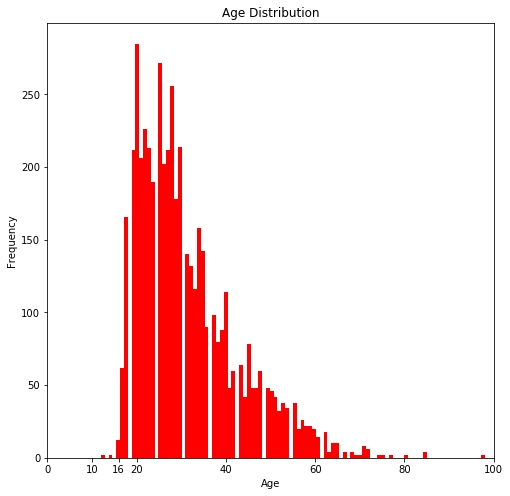

In [37]:
inches_wide = 8
inches_high = 8
plt.rcParams["figure.figsize"] = [inches_wide, inches_high]
ax = trial_df.SubjectAge.plot.hist(xlim=(0,100), bins=100, color='red', xticks = [0, 10, 16, 20, 40, 60, 80, 100], title = "Age Distribution");
ax.set_xlabel("Age")
axis = plt.gca();

In [38]:
trial_df.SubjectEthnicityCode.value_counts()

N    3720
H    1280
Name: SubjectEthnicityCode, dtype: int64

In [39]:
train_df.SubjectEthnicityCode.value_counts()

N    53177
H    15831
M      871
Name: SubjectEthnicityCode, dtype: int64

In [40]:
train_df.SubjectRaceCode.value_counts()

W    48969
B    20259
A      460
I      191
Name: SubjectRaceCode, dtype: int64

In [41]:
trial_df.SubjectRaceCode.value_counts()

W    3333
B    1611
A      46
I      10
Name: SubjectRaceCode, dtype: int64

In [42]:
train_df.SubjectSexCode.value_counts()

M    57135
F    12744
Name: SubjectSexCode, dtype: int64

In [43]:
trial_df.SubjectSexCode.value_counts()

M    3955
F    1045
Name: SubjectSexCode, dtype: int64

In [44]:
train_df.TownResidentIndicator.value_counts()

False    42247
True     27632
Name: TownResidentIndicator, dtype: int64

In [45]:
trial_df.TownResidentIndicator.value_counts()

False    2772
True     2228
Name: TownResidentIndicator, dtype: int64

In [46]:
train_df.shape

(69879, 15)

In [47]:
trial_df.shape

(5000, 18)

In [48]:
trial_df.head()

,id,observation_id,proba,true_class,predicted_class,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
5,11,10,0.562560,1.0,1,New Britain,05/16/2018 01:19:00 PM,New Britain,V,684,False,O,Window Tint,30.0,N,B,M,True
6,12,11,0.562560,1.0,1,New Britain,05/16/2018 01:19:00 PM,New Britain,V,684,False,O,Window Tint,30.0,N,B,M,True
8,14,13,0.276715,1.0,0,CSP Troop C,05/16/2018 02:36:00 PM,ELLINGTON,V,1000003160,False,C,Speed Related,48.0,N,W,F,False
7,13,12,0.276715,1.0,0,CSP Troop C,05/16/2018 02:36:00 PM,ELLINGTON,V,1000003160,False,C,Speed Related,48.0,N,W,F,False
1816,2,0,0.388104,0.0,1,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False


Section Model Performance

In [49]:
precision, recall, thresholds = precision_recall_curve(trial_df.true_class, trial_df.proba)

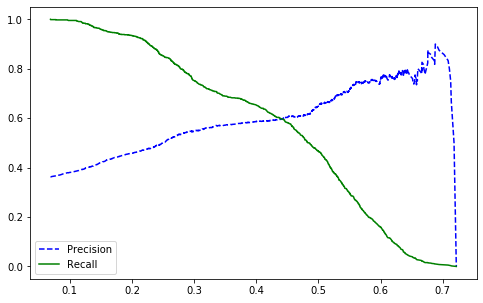

In [50]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [51]:
trial_df.proba.max()

0.721912

In [52]:
thresholds

array([0.0688828, 0.0690821, 0.0693104, ..., 0.713868 , 0.718265 ,
       0.721912 ])

In [53]:
precision[-10:]

array([0.88888889, 0.875     , 0.85714286, 0.83333333, 0.8       ,
       0.75      , 0.66666667, 0.5       , 0.        , 1.        ])

In [54]:
recall[-10:]

array([0.00891365, 0.00779944, 0.00668524, 0.00557103, 0.00445682,
       0.00334262, 0.00222841, 0.00111421, 0.        , 0.        ])

In [55]:
precision[:-1][np.greater_equal(thresholds, [0.3873617971247522])][0]

0.5825575698187163

In [56]:
recall[:-1][np.greater_equal(thresholds, [0.3873617971247522])][0]

0.6623955431754874

In [57]:
fpr, tpr, _ = roc_curve(trial_df.true_class, trial_df.proba)
roc_auc = auc(fpr, tpr)

In [58]:
%matplotlib inline

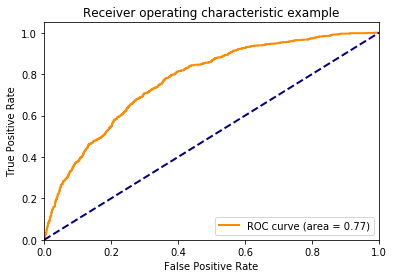

In [59]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [60]:
roc = roc_auc_score(trial_df.true_class, trial_df.proba)
roc

0.7717334074978598

Sections Population analysis and Unexpected Problems

In [61]:
#check for duplicates. Make sure to comment the line 
#trial_df = trial_df[(trial_df.true_class == 1) | (trial_df.true_class == 0)]
#otherwise the analysis won't include the full dataset
'''trial_df_dup = trial_df.drop(columns=["id", "observation_id", 'true_class'])
print(trial_df_dup.drop_duplicates(keep="first").shape)
print(trial_df_dup.shape)
trial_df_b = trial_df[(trial_df.true_class == 1) | (trial_df.true_class == 0)]
print(trial_df_b.shape)
print(trial_df_b.drop(columns=["id", "observation_id", 'true_class']).drop_duplicates(keep="first").shape)'''

'trial_df_dup = trial_df.drop(columns=["id", "observation_id", \'true_class\'])\nprint(trial_df_dup.drop_duplicates(keep="first").shape)\nprint(trial_df_dup.shape)\ntrial_df_b = trial_df[(trial_df.true_class == 1) | (trial_df.true_class == 0)]\nprint(trial_df_b.shape)\nprint(trial_df_b.drop(columns=["id", "observation_id", \'true_class\']).drop_duplicates(keep="first").shape)'